# Quickstart: Building a GenAI powered Semantic Intelligence with Intugle

This quickstart shows you how to use Intugle’s open-source library to transform fragmented datasets into a connected semantic layer. The semantic layer captures profiling, relationships, and business meaning of your data — making it instantly usable for exploration, search, and data product creation.

**What is Semantic Intelligence?**

A semantic layer is an intelligent knowledge graph of your data. It connects tables, discovers relationships, and enriches them with business glossaries — so both data teams and business users can query with clarity, not complexity.

**Who is this for?**

*   **Data Engineers & Architects** often spend weeks manually profiling, classifying, and stitching together fragmented data assets. With Intugle, they can automate this process end-to-end, uncovering meaningful links and relationships to instantly generate a connected semantic layer.
*   **Data Analysts & Scientists** spend endless hours on data readiness and preparation before they can even start the real analysis. Intugle accelerates this by providing contextual intelligence, automatically generating SQL and reusable data products enriched with relationships and business meaning.
*   **Business Analysts & Decision Makers** are slowed down by constant dependence on technical teams for answers. Intugle removes this bottleneck by enabling natural language queries and semantic search, giving them trusted insights on demand.

**In this notebook, you will learn how to:**

- **Profile and classify data** : Analyze your data sources to understand their structure, data types, and other characteristics.
- **Discover links & relationships among data** : Reveal meaningful connections (PK & FK) across fragmented tables.
- **Generate a business glossary & enable semantic search** : Create business-friendly terms and use them to query data with context.
- **Create a semantic intelligence layer** : Build a unified model (YAML) of your data and relationships.
- **Build unified data products** : Generate reusable SQL queries powered by the semantic layer.

Before you start, make sure you install the **Intugle Data Tools**:

In [ ]:
%pip install intugle

## 1. LLM Configuration

Before running the project, you need to configure a Large Language Model (LLM). This is used for tasks like generating business glossaries and predicting links between tables. For the semantic search feature, you will also need to set up Qdrant and provide an OpenAI API key. For detailed setup instructions, please refer to the [README.md](README.md) file.

You can configure the necessary services by setting the following environment variables:

*   `LLM_PROVIDER`: The LLM provider and model to use (e.g., `openai:gpt-3.5-turbo`). The format follows langchain's format for initializing chat models. Checkout how to specify your model [here](https://python.langchain.com/docs/integrations/chat/)
*   `API_KEY`: Your API key for the LLM provider. The exact name of the variable may vary from provider to provider (e.g., `OPENAI_API_KEY`, `ANTHROPIC_API_KEY`).
*   `QDRANT_URL`: The URL of your Qdrant instance (e.g., `http://localhost:6333`).
*   `QDRANT_API_KEY`: Your API key for the Qdrant instance, if authorization is enabled.
*   `EMBEDDING_MODEL_NAME`: The embedding model to use. The format follows LangChain's conventions for initializing embedding models (e.g., `openai:ada`, `azure_openai:ada`).
*   `OPENAI_API_KEY`: Your OpenAI API key, required if you are using an OpenAI embedding model.
*   `AZURE_OPENAI_API_KEY`, `AZURE_OPENAI_ENDPOINT`, `OPENAI_API_VERSION`: Your Azure OpenAI credentials, required if you are using an Azure OpenAI embedding model.

Here's an example of how to set these variables in your environment:

```bash
export LLM_PROVIDER="openai:gpt-3.5-turbo"
export OPENAI_API_KEY="your-openai-api-key"
```
Alternatively, you can set them in the notebook like this:

In [ ]:
import os

os.environ["LLM_PROVIDER"] = "openai:gpt-3.5-turbo"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"  # Replace with your actual key

# Semantic Search Configuration (Optional)
os.environ["QDRANT_URL"] = "http://localhost:6333"
os.environ["QDRANT_API_KEY"] = "" # if authorization is used
os.environ["EMBEDDING_MODEL_NAME"] = "openai:ada"
os.environ["OPENAI_API_KEY"] = "your-openai-api-key"

# For Azure OpenAI models
os.environ["EMBEDDING_MODEL_NAME"] = "azure_openai:ada"
os.environ["AZURE_OPENAI_API_KEY"] = "your-azure-openai-api-key"
os.environ["AZURE_OPENAI_ENDPOINT"] = "your-azure-openai-endpoint"
os.environ["OPENAI_API_VERSION"] = "your-openai-api-version"



> Currently the langchain packages for OpenAI, Anthropic and Gemini is installed by default. For additional models, make sure you have the integration packages installed. E.g. you should have langchain-deepseek installed to use a DeepSeek model. You can get these packages here: [LangChain Chat Models](https://python.langchain.com/docs/integrations/chat/)

## 2. Building the Knowledge Base

The `KnowledgeBuilder` is the entry point for building your semantic layer. It takes a dictionary of datasets as input and performs the following steps:

1.  **Data Profiling:** Calculates statistics for each column, such as distinct count, uniqueness, and completeness.
2.  **Datatype Identification:** Identifies the data type of each column (e.g., integer, string, datetime).
3.  **Key Identification:** Identifies potential primary keys.
4.  **Glossary Generation:** Generates a business glossary for each column using an LLM.
5.  **Link Prediction:** Predicts the relationships (foreign keys) between tables.

Let's start by defining the datasets we want to use. The path shown below can be a local file path or a remote URL.

In [ ]:
def generate_config(table_name: str, source: str = "local") -> dict[str, str]:
    """Generate dataset config for local or remote files."""
    path = f"https://raw.githubusercontent.com/Intugle/data-tools/refs/heads/main/sample_data/tech_company/{table_name}.csv"    
    return {
        "path": path,
        "type": "csv"
    }


table_names = [
    "campaign_survey",
    "campaigns",
    "customer_hierarchy",
    "customers",
    "delivery_survey",
    "expense",
    "install_base",
    "inventory",
    "logistics",
    "nps_survey",
    "opportunity",
    "orders",
    "prob_statement_issue",
    "product_feature",
    "product_hierarchy",
    "products",
    "renewals",
    "returns",
    "service_requests",
    "website"
]


datasets = {table: generate_config(table) for table in table_names}

Now, let's use the `KnowledgeBuilder` to build our semantic layer:

> The `domain` parameter helps the LLM generate a more contextual business glossary. It specifies the industry domain that the dataset belongs to (e.g., "Healthcare", "Finance", "E-commerce").

In [3]:
from intugle import KnowledgeBuilder

# Initialize the knowledge builder
kb = KnowledgeBuilder(datasets, domain="Technology Company")

# Run the prediction
kb.build()

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "schema" in "Source" shadows an attribute in parent "BaseResource"
  warnings.warn(


campaign_survey loaded
campaigns loaded
customer_hierarchy loaded
customers loaded
delivery_survey loaded
expense loaded
install_base loaded
inventory loaded
logistics loaded
nps_survey loaded
opportunity loaded
orders loaded
prob_statement_issue loaded
product_feature loaded
product_hierarchy loaded
products loaded
renewals loaded
returns loaded
service_requests loaded
website loaded


/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3859: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
[*] campaign_survey:   0%|          | 0/1 [00:00<?, ?it/s]/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/pipeline/key_identification/ki.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.rename(columns={"datatype_l1": "datatype"}, inplace=True)
100%|██████████| 9/9 [00:13<00:00,  1.50s/it]
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/numpy/_core/fromnumeric

Dataset 'campaign_survey' already processed. Skipping analysis.
Dataset 'campaigns' already processed. Skipping analysis.
Dataset 'customer_hierarchy' already processed. Skipping analysis.
Dataset 'customers' already processed. Skipping analysis.
Dataset 'delivery_survey' already processed. Skipping analysis.
Dataset 'expense' already processed. Skipping analysis.
Dataset 'install_base' already processed. Skipping analysis.
Dataset 'inventory' already processed. Skipping analysis.
Dataset 'logistics' already processed. Skipping analysis.
Dataset 'nps_survey' already processed. Skipping analysis.
Dataset 'opportunity' already processed. Skipping analysis.
Dataset 'orders' already processed. Skipping analysis.
Dataset 'prob_statement_issue' already processed. Skipping analysis.
Dataset 'product_feature' already processed. Skipping analysis.
Dataset 'product_hierarchy' already processed. Skipping analysis.
Dataset 'products' already processed. Skipping analysis.
Dataset 'renewals' already

[*] campaign_survey <==> campaigns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 potential link(s).

--- Comparing 'campaign_survey' <=> 'customer_hierarchy' ---


[*] campaign_survey <==> customer_hierarchy Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'customers' ---


[*] campaign_survey <==> customers Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'delivery_survey' ---


[*] campaign_survey <==> delivery_survey Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'expense' ---


[*] campaign_survey <==> expense Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'install_base' ---


[*] campaign_survey <==> install_base Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'inventory' ---


[*] campaign_survey <==> inventory Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.07it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'logistics' ---


[*] campaign_survey <==> logistics Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'nps_survey' ---


[*] campaign_survey <==> nps_survey Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'opportunity' ---


[*] campaign_survey <==> opportunity Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'orders' ---


[*] campaign_survey <==> orders Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'prob_statement_issue' ---


[*] campaign_survey <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'product_feature' ---


[*] campaign_survey <==> product_feature Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'product_hierarchy' ---


[*] campaign_survey <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'products' ---


[*] campaign_survey <==> products Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'renewals' ---


[*] campaign_survey <==> renewals Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'returns' ---


[*] campaign_survey <==> returns Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'service_requests' ---


[*] campaign_survey <==> service_requests Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


No links found for this pair.

--- Comparing 'campaign_survey' <=> 'website' ---


[*] campaign_survey <==> website Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'customer_hierarchy' ---


[*] campaigns <==> customer_hierarchy Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.93s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'customers' ---


[*] campaigns <==> customers Runs:1: 100%|██████████| 1/1 [00:11<00:00, 11.43s/it]


Found 1 potential link(s).

--- Comparing 'campaigns' <=> 'delivery_survey' ---


[*] campaigns <==> delivery_survey Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'expense' ---


[*] campaigns <==> expense Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.29s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'install_base' ---


[*] campaigns <==> install_base Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.99s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'inventory' ---


[*] campaigns <==> inventory Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.30s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'logistics' ---


[*] campaigns <==> logistics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'nps_survey' ---


[*] campaigns <==> nps_survey Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'opportunity' ---


[*] campaigns <==> opportunity Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'orders' ---


[*] campaigns <==> orders Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.43s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'prob_statement_issue' ---


[*] campaigns <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'product_feature' ---


[*] campaigns <==> product_feature Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'product_hierarchy' ---


[*] campaigns <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.44s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'products' ---


[*] campaigns <==> products Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]


Found 1 potential link(s).

--- Comparing 'campaigns' <=> 'renewals' ---


[*] campaigns <==> renewals Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'returns' ---


[*] campaigns <==> returns Runs:1: 100%|██████████| 1/1 [00:12<00:00, 12.29s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'service_requests' ---


[*] campaigns <==> service_requests Runs:1: 100%|██████████| 1/1 [00:11<00:00, 11.56s/it]


No links found for this pair.

--- Comparing 'campaigns' <=> 'website' ---


[*] campaigns <==> website Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


Found 1 potential link(s).

--- Comparing 'customer_hierarchy' <=> 'customers' ---


[*] customer_hierarchy <==> customers Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 potential link(s).

--- Comparing 'customer_hierarchy' <=> 'delivery_survey' ---


[*] customer_hierarchy <==> delivery_survey Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'expense' ---


[*] customer_hierarchy <==> expense Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'install_base' ---


[*] customer_hierarchy <==> install_base Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'inventory' ---


[*] customer_hierarchy <==> inventory Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.97s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'logistics' ---


[*] customer_hierarchy <==> logistics Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.58s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'nps_survey' ---


[*] customer_hierarchy <==> nps_survey Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'opportunity' ---


[*] customer_hierarchy <==> opportunity Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'orders' ---


[*] customer_hierarchy <==> orders Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'prob_statement_issue' ---


[*] customer_hierarchy <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'product_feature' ---


[*] customer_hierarchy <==> product_feature Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'product_hierarchy' ---


[*] customer_hierarchy <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'products' ---


[*] customer_hierarchy <==> products Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'renewals' ---


[*] customer_hierarchy <==> renewals Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'returns' ---


[*] customer_hierarchy <==> returns Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'service_requests' ---


[*] customer_hierarchy <==> service_requests Runs:1: 100%|██████████| 1/1 [00:15<00:00, 16.00s/it]


No links found for this pair.

--- Comparing 'customer_hierarchy' <=> 'website' ---


[*] customer_hierarchy <==> website Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.36s/it]


No links found for this pair.

--- Comparing 'customers' <=> 'delivery_survey' ---


[*] customers <==> delivery_survey Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'expense' ---


[*] customers <==> expense Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.01s/it]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'install_base' ---


[*] customers <==> install_base Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.15s/it]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'inventory' ---


[*] customers <==> inventory Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


No links found for this pair.

--- Comparing 'customers' <=> 'logistics' ---


[*] customers <==> logistics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'nps_survey' ---


[*] customers <==> nps_survey Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'opportunity' ---


[*] customers <==> opportunity Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'orders' ---


[*] customers <==> orders Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'prob_statement_issue' ---


[*] customers <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]


No links found for this pair.

--- Comparing 'customers' <=> 'product_feature' ---


[*] customers <==> product_feature Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


No links found for this pair.

--- Comparing 'customers' <=> 'product_hierarchy' ---


[*] customers <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


No links found for this pair.

--- Comparing 'customers' <=> 'products' ---


[*] customers <==> products Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]


No links found for this pair.

--- Comparing 'customers' <=> 'renewals' ---


[*] customers <==> renewals Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'returns' ---


[*] customers <==> returns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'service_requests' ---


[*] customers <==> service_requests Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Found 1 potential link(s).

--- Comparing 'customers' <=> 'website' ---


[*] customers <==> website Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.05it/s]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'expense' ---


[*] delivery_survey <==> expense Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'install_base' ---


[*] delivery_survey <==> install_base Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 potential link(s).

--- Comparing 'delivery_survey' <=> 'inventory' ---


[*] delivery_survey <==> inventory Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'logistics' ---


[*] delivery_survey <==> logistics Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'nps_survey' ---


[*] delivery_survey <==> nps_survey Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'opportunity' ---


[*] delivery_survey <==> opportunity Runs:1: 100%|██████████| 1/1 [00:09<00:00,  9.58s/it]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'orders' ---


[*] delivery_survey <==> orders Runs:1: 100%|██████████| 1/1 [00:10<00:00, 10.19s/it]


Found 1 potential link(s).

--- Comparing 'delivery_survey' <=> 'prob_statement_issue' ---


[*] delivery_survey <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.08s/it]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'product_feature' ---


[*] delivery_survey <==> product_feature Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.39s/it]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'product_hierarchy' ---


[*] delivery_survey <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.23s/it]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'products' ---


[*] delivery_survey <==> products Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Found 1 potential link(s).

--- Comparing 'delivery_survey' <=> 'renewals' ---


[*] delivery_survey <==> renewals Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


Found 1 potential link(s).

--- Comparing 'delivery_survey' <=> 'returns' ---


[*] delivery_survey <==> returns Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]


Found 1 potential link(s).

--- Comparing 'delivery_survey' <=> 'service_requests' ---


[*] delivery_survey <==> service_requests Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.48s/it]


No links found for this pair.

--- Comparing 'delivery_survey' <=> 'website' ---


[*] delivery_survey <==> website Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'install_base' ---


[*] expense <==> install_base Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'inventory' ---


[*] expense <==> inventory Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 potential link(s).

--- Comparing 'expense' <=> 'logistics' ---


[*] expense <==> logistics Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'nps_survey' ---


[*] expense <==> nps_survey Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'opportunity' ---


[*] expense <==> opportunity Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'orders' ---


[*] expense <==> orders Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'prob_statement_issue' ---


[*] expense <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.00s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'product_feature' ---


[*] expense <==> product_feature Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.87s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'product_hierarchy' ---


[*] expense <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'products' ---


[*] expense <==> products Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'renewals' ---


[*] expense <==> renewals Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'returns' ---


[*] expense <==> returns Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'service_requests' ---


[*] expense <==> service_requests Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


No links found for this pair.

--- Comparing 'expense' <=> 'website' ---


[*] expense <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


No links found for this pair.

--- Comparing 'install_base' <=> 'inventory' ---


[*] install_base <==> inventory Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


No links found for this pair.

--- Comparing 'install_base' <=> 'logistics' ---


[*] install_base <==> logistics Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


Found 1 potential link(s).

--- Comparing 'install_base' <=> 'nps_survey' ---


[*] install_base <==> nps_survey Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.61s/it]


No links found for this pair.

--- Comparing 'install_base' <=> 'opportunity' ---


[*] install_base <==> opportunity Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


No links found for this pair.

--- Comparing 'install_base' <=> 'orders' ---


[*] install_base <==> orders Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


Found 1 potential link(s).

--- Comparing 'install_base' <=> 'prob_statement_issue' ---


[*] install_base <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


No links found for this pair.

--- Comparing 'install_base' <=> 'product_feature' ---


[*] install_base <==> product_feature Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


No links found for this pair.

--- Comparing 'install_base' <=> 'product_hierarchy' ---


[*] install_base <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.25s/it]


No links found for this pair.

--- Comparing 'install_base' <=> 'products' ---


[*] install_base <==> products Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 potential link(s).

--- Comparing 'install_base' <=> 'renewals' ---


[*] install_base <==> renewals Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Found 1 potential link(s).

--- Comparing 'install_base' <=> 'returns' ---


[*] install_base <==> returns Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.47s/it]


Found 1 potential link(s).

--- Comparing 'install_base' <=> 'service_requests' ---


[*] install_base <==> service_requests Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.28s/it]


Found 1 potential link(s).

--- Comparing 'install_base' <=> 'website' ---


[*] install_base <==> website Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'logistics' ---


[*] inventory <==> logistics Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.64s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'nps_survey' ---


[*] inventory <==> nps_survey Runs:1: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'opportunity' ---


[*] inventory <==> opportunity Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'orders' ---


[*] inventory <==> orders Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'prob_statement_issue' ---


[*] inventory <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.68s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'product_feature' ---


[*] inventory <==> product_feature Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'product_hierarchy' ---


[*] inventory <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'products' ---


[*] inventory <==> products Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


Found 1 potential link(s).

--- Comparing 'inventory' <=> 'renewals' ---


[*] inventory <==> renewals Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'returns' ---


[*] inventory <==> returns Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.12s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'service_requests' ---


[*] inventory <==> service_requests Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it]


No links found for this pair.

--- Comparing 'inventory' <=> 'website' ---


[*] inventory <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


No links found for this pair.

--- Comparing 'logistics' <=> 'nps_survey' ---


[*] logistics <==> nps_survey Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


No links found for this pair.

--- Comparing 'logistics' <=> 'opportunity' ---


[*] logistics <==> opportunity Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


No links found for this pair.

--- Comparing 'logistics' <=> 'orders' ---


[*] logistics <==> orders Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.00s/it]


Found 1 potential link(s).

--- Comparing 'logistics' <=> 'prob_statement_issue' ---


[*] logistics <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


No links found for this pair.

--- Comparing 'logistics' <=> 'product_feature' ---


[*] logistics <==> product_feature Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s]


No links found for this pair.

--- Comparing 'logistics' <=> 'product_hierarchy' ---


[*] logistics <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.12s/it]


No links found for this pair.

--- Comparing 'logistics' <=> 'products' ---


[*] logistics <==> products Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.61s/it]


No links found for this pair.

--- Comparing 'logistics' <=> 'renewals' ---


[*] logistics <==> renewals Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


Found 1 potential link(s).

--- Comparing 'logistics' <=> 'returns' ---


[*] logistics <==> returns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.38it/s]


Found 1 potential link(s).

--- Comparing 'logistics' <=> 'service_requests' ---


[*] logistics <==> service_requests Runs:1: 100%|██████████| 1/1 [00:15<00:00, 15.87s/it]


No links found for this pair.

--- Comparing 'logistics' <=> 'website' ---


[*] logistics <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


No links found for this pair.

--- Comparing 'nps_survey' <=> 'opportunity' ---


[*] nps_survey <==> opportunity Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


No links found for this pair.

--- Comparing 'nps_survey' <=> 'orders' ---


[*] nps_survey <==> orders Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]


No links found for this pair.

--- Comparing 'nps_survey' <=> 'prob_statement_issue' ---


[*] nps_survey <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


Found 1 potential link(s).

--- Comparing 'nps_survey' <=> 'product_feature' ---


[*] nps_survey <==> product_feature Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


No links found for this pair.

--- Comparing 'nps_survey' <=> 'product_hierarchy' ---


[*] nps_survey <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


No links found for this pair.

--- Comparing 'nps_survey' <=> 'products' ---


[*] nps_survey <==> products Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


No links found for this pair.

--- Comparing 'nps_survey' <=> 'renewals' ---


[*] nps_survey <==> renewals Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.47s/it]


No links found for this pair.

--- Comparing 'nps_survey' <=> 'returns' ---


[*] nps_survey <==> returns Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Found 1 potential link(s).

--- Comparing 'nps_survey' <=> 'service_requests' ---


[*] nps_survey <==> service_requests Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


Found 1 potential link(s).

--- Comparing 'nps_survey' <=> 'website' ---


[*] nps_survey <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


No links found for this pair.

--- Comparing 'opportunity' <=> 'orders' ---


[*] opportunity <==> orders Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it]


No links found for this pair.

--- Comparing 'opportunity' <=> 'prob_statement_issue' ---


[*] opportunity <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


No links found for this pair.

--- Comparing 'opportunity' <=> 'product_feature' ---


[*] opportunity <==> product_feature Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]


No links found for this pair.

--- Comparing 'opportunity' <=> 'product_hierarchy' ---


[*] opportunity <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.38s/it]


No links found for this pair.

--- Comparing 'opportunity' <=> 'products' ---


[*] opportunity <==> products Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.26s/it]


No links found for this pair.

--- Comparing 'opportunity' <=> 'renewals' ---


[*] opportunity <==> renewals Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]


No links found for this pair.

--- Comparing 'opportunity' <=> 'returns' ---


[*] opportunity <==> returns Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.36s/it]


No links found for this pair.

--- Comparing 'opportunity' <=> 'service_requests' ---


[*] opportunity <==> service_requests Runs:1: 100%|██████████| 1/1 [00:07<00:00,  7.86s/it]


No links found for this pair.

--- Comparing 'opportunity' <=> 'website' ---


[*] opportunity <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


No links found for this pair.

--- Comparing 'orders' <=> 'prob_statement_issue' ---


[*] orders <==> prob_statement_issue Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.75s/it]


No links found for this pair.

--- Comparing 'orders' <=> 'product_feature' ---


[*] orders <==> product_feature Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]


No links found for this pair.

--- Comparing 'orders' <=> 'product_hierarchy' ---


[*] orders <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.81s/it]


No links found for this pair.

--- Comparing 'orders' <=> 'products' ---


[*] orders <==> products Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Found 1 potential link(s).

--- Comparing 'orders' <=> 'renewals' ---


[*] orders <==> renewals Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


Found 1 potential link(s).

--- Comparing 'orders' <=> 'returns' ---


[*] orders <==> returns Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Found 1 potential link(s).

--- Comparing 'orders' <=> 'service_requests' ---


[*] orders <==> service_requests Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Found 1 potential link(s).

--- Comparing 'orders' <=> 'website' ---


[*] orders <==> website Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]


No links found for this pair.

--- Comparing 'prob_statement_issue' <=> 'product_feature' ---


[*] prob_statement_issue <==> product_feature Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


No links found for this pair.

--- Comparing 'prob_statement_issue' <=> 'product_hierarchy' ---


[*] prob_statement_issue <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


No links found for this pair.

--- Comparing 'prob_statement_issue' <=> 'products' ---


[*] prob_statement_issue <==> products Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


Found 1 potential link(s).

--- Comparing 'prob_statement_issue' <=> 'renewals' ---


[*] prob_statement_issue <==> renewals Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.84s/it]


No links found for this pair.

--- Comparing 'prob_statement_issue' <=> 'returns' ---


[*] prob_statement_issue <==> returns Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.04s/it]


Found 1 potential link(s).

--- Comparing 'prob_statement_issue' <=> 'service_requests' ---


[*] prob_statement_issue <==> service_requests Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 potential link(s).

--- Comparing 'prob_statement_issue' <=> 'website' ---


[*] prob_statement_issue <==> website Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


No links found for this pair.

--- Comparing 'product_feature' <=> 'product_hierarchy' ---


[*] product_feature <==> product_hierarchy Runs:1: 100%|██████████| 1/1 [00:06<00:00,  6.31s/it]


No links found for this pair.

--- Comparing 'product_feature' <=> 'products' ---


[*] product_feature <==> products Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


Found 1 potential link(s).

--- Comparing 'product_feature' <=> 'renewals' ---


[*] product_feature <==> renewals Runs:1: 100%|██████████| 1/1 [00:05<00:00,  5.66s/it]


No links found for this pair.

--- Comparing 'product_feature' <=> 'returns' ---


[*] product_feature <==> returns Runs:1: 100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


No links found for this pair.

--- Comparing 'product_feature' <=> 'service_requests' ---


[*] product_feature <==> service_requests Runs:1: 100%|██████████| 1/1 [00:08<00:00,  8.73s/it]


No links found for this pair.

--- Comparing 'product_feature' <=> 'website' ---


[*] product_feature <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


No links found for this pair.

--- Comparing 'product_hierarchy' <=> 'products' ---


[*] product_hierarchy <==> products Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


Found 1 potential link(s).

--- Comparing 'product_hierarchy' <=> 'renewals' ---


[*] product_hierarchy <==> renewals Runs:1: 100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


No links found for this pair.

--- Comparing 'product_hierarchy' <=> 'returns' ---


[*] product_hierarchy <==> returns Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


No links found for this pair.

--- Comparing 'product_hierarchy' <=> 'service_requests' ---


[*] product_hierarchy <==> service_requests Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


No links found for this pair.

--- Comparing 'product_hierarchy' <=> 'website' ---


[*] product_hierarchy <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.19s/it]


No links found for this pair.

--- Comparing 'products' <=> 'renewals' ---


[*] products <==> renewals Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]


Found 1 potential link(s).

--- Comparing 'products' <=> 'returns' ---


[*] products <==> returns Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]


Found 1 potential link(s).

--- Comparing 'products' <=> 'service_requests' ---


[*] products <==> service_requests Runs:1: 100%|██████████| 1/1 [00:02<00:00,  2.07s/it]


Found 1 potential link(s).

--- Comparing 'products' <=> 'website' ---


[*] products <==> website Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


No links found for this pair.

--- Comparing 'renewals' <=> 'returns' ---


[*] renewals <==> returns Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.31s/it]


Found 1 potential link(s).

--- Comparing 'renewals' <=> 'service_requests' ---


[*] renewals <==> service_requests Runs:1: 100%|██████████| 1/1 [00:01<00:00,  2.00s/it]


No links found for this pair.

--- Comparing 'renewals' <=> 'website' ---


[*] renewals <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


No links found for this pair.

--- Comparing 'returns' <=> 'service_requests' ---


[*] returns <==> service_requests Runs:1: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]


Found 1 potential link(s).

--- Comparing 'returns' <=> 'website' ---


[*] returns <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.21s/it]


No links found for this pair.

--- Comparing 'service_requests' <=> 'website' ---


[*] service_requests <==> website Runs:1: 100%|██████████| 1/1 [00:01<00:00,  1.03s/it]


No links found for this pair.


/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
ERROR:intugle.core.vector_store.qdrant:AsyncQdrantService: Couldn't create collection, reason: All connection attempts failed


## 3. Accessing Enriched Metadata

Now that the knowledge base is built, you can easily access the enriched metadata for each dataset.

### Accessing a Dataset

You can access a specific dataset by its name from the `kb.datasets` dictionary:

In [4]:
products_dataset = kb.datasets['products']
products_dataset.profiling_df


,column_name,business_name,table_name,null_count,count,distinct_count,uniqueness,completeness,sample_data,dtype_sample,ts,datatype_l1,datatype_l2,business_glossary,business_tags
0,Product ID,product_id,products,0,1000,1000,1.000,1.0,"[PROD-11043, PROD-11099, PROD-11232, PROD-1126...","[PROD-11012, PROD-11024, PROD-11044, PROD-1107...",0.011418,alphanumeric,L2OutputTypes.dimension,Uniquely identifies a product within the compa...,"[Product Identifier, Inventory Management, Cat..."
1,Product Name,product_name,products,0,1000,5,0.005,1.0,"[NetConnect, DataSphere, CloudEdge, Insight360...","[DataSphere, Insight360, CloudEdge, NetConnect...",0.010229,alphanumeric,L2OutputTypes.dimension,Identifies the name used to distinguish and ma...,"[Product Catalog, Product Identification, Busi..."
2,Product Category,product_category,products,0,1000,5,0.005,1.0,"[Security, Networking, IoT, Analytics, Cloud P...","[Networking, Analytics, Cloud Platform, Securi...",0.010934,close_ended_text,L2OutputTypes.dimension,Groups products into distinct classifications ...,"[Product Classification, Business Offering, Ma..."
3,Product Status,product_status,products,0,1000,5,0.005,1.0,"[Pilot, In Development, Active, GA (General Av...","[In Development, GA (General Availability), Ac...",0.013689,close_ended_text,L2OutputTypes.dimension,Indicates the current lifecycle phase of a pro...,"[Lifecycle Management, Product State, Operatio..."
4,R&D Initiation Date,r_d_initiation_date,products,0,1000,777,0.777,1.0,"[2021-05-07, 2024-02-03, 2021-11-23, 2025-08-0...","[2023-10-19, 2025-02-08, 2023-11-10, 2023-08-0...",0.009860,date & time,L2OutputTypes.dimension,Indicates the date on which the research and d...,"[Research And Development, Project Initiation ..."
5,R&D Stage,r_d_stage,products,0,1000,5,0.005,1.0,"[Pre-Launch, Prototype, Concept, Enhancement, ...","[Enhancement, Pre-Launch, Concept, Prototype, ...",0.015447,close_ended_text,L2OutputTypes.dimension,Indicates the current phase of development and...,"[Product Development Lifecycle, Innovation Man..."
6,Launch Status,launch_status,products,0,1000,5,0.005,1.0,"[Not Launched, Launched, Planned, In Pipeline,...","[In Pipeline, Planned, Launched, Not Launched,...",0.014008,close_ended_text,L2OutputTypes.dimension,Indicates the current phase or outcome of a pr...,"[Product Lifecycle, Launch Planning, Operation..."
7,Launch Date,launch_date,products,0,1000,659,0.659,1.0,"[2025-07-20, 2025-08-15, 2023-05-12, 2022-09-2...","[2023-08-04, 2024-09-02, 2025-03-16, 2023-10-0...",0.009879,date & time,L2OutputTypes.dimension,The date on which a product becomes available ...,"[Product Launch Timeline, Go-To-Market Strateg..."
8,PM Name,pm_name,products,0,1000,994,0.994,1.0,"[Daniel Cox, Joshua Pacheco, Erica Hines, Rube...","[William Rodgers, Dawn Harris MD, Shannon Osbo...",0.011669,close_ended_text,L2OutputTypes.dimension,Identifies the individual responsible for mana...,"[Product Manager, Team Ownership, Project Lead..."
9,Product Cost ($),product_cost,products,0,1000,998,0.998,1.0,"[267011, 244939, 176900, 363770, 230504, 58687...","[222364, 571000, 335185, 558107, 598668, 26134...",0.012803,integer,L2OutputTypes.measure,Indicates the monetary expense incurred to pro...,"[Product Pricing, Cost Analysis, Financial Met..."


The profiling results can be accessed through the `profiling_df` property of the `DataSet` object. It's a pandas DataFrame that you can easily explore. 
> The business glossary is also available in the `profiling_df`:


### Visualizing Relationships

The `KnowledgeBuilder` automatically discovers the relationships between your tables. You can access the predicted links as a list of `PredictedLink` objects:


In [5]:
kb.links

[PredictedLink(from_dataset='campaign_survey', from_column='Camp ID', to_dataset='campaigns', to_column='Campaign ID'),
 PredictedLink(from_dataset='campaigns', from_column='Prospect ID', to_dataset='customers', to_column='C_ID'),
 PredictedLink(from_dataset='campaigns', from_column='Prod_ID', to_dataset='products', to_column='Product ID'),
 PredictedLink(from_dataset='campaigns', from_column='Campaign ID', to_dataset='website', to_column='Cmgn ID'),
 PredictedLink(from_dataset='customer_hierarchy', from_column='Party ID', to_dataset='customers', to_column='C_ID'),
 PredictedLink(from_dataset='customers', from_column='C_ID', to_dataset='delivery_survey', to_column='Customer ID'),
 PredictedLink(from_dataset='customers', from_column='C_ID', to_dataset='expense', to_column='Contact ID'),
 PredictedLink(from_dataset='customers', from_column='C_ID', to_dataset='install_base', to_column='Party ID'),
 PredictedLink(from_dataset='customers', from_column='C_ID', to_dataset='logistics', to_colu

You can also visualize these relationships as a graph. In case you run into an error, make sure you install/upgrade your ipykernel package:
> %pip install --upgrade ipykernel

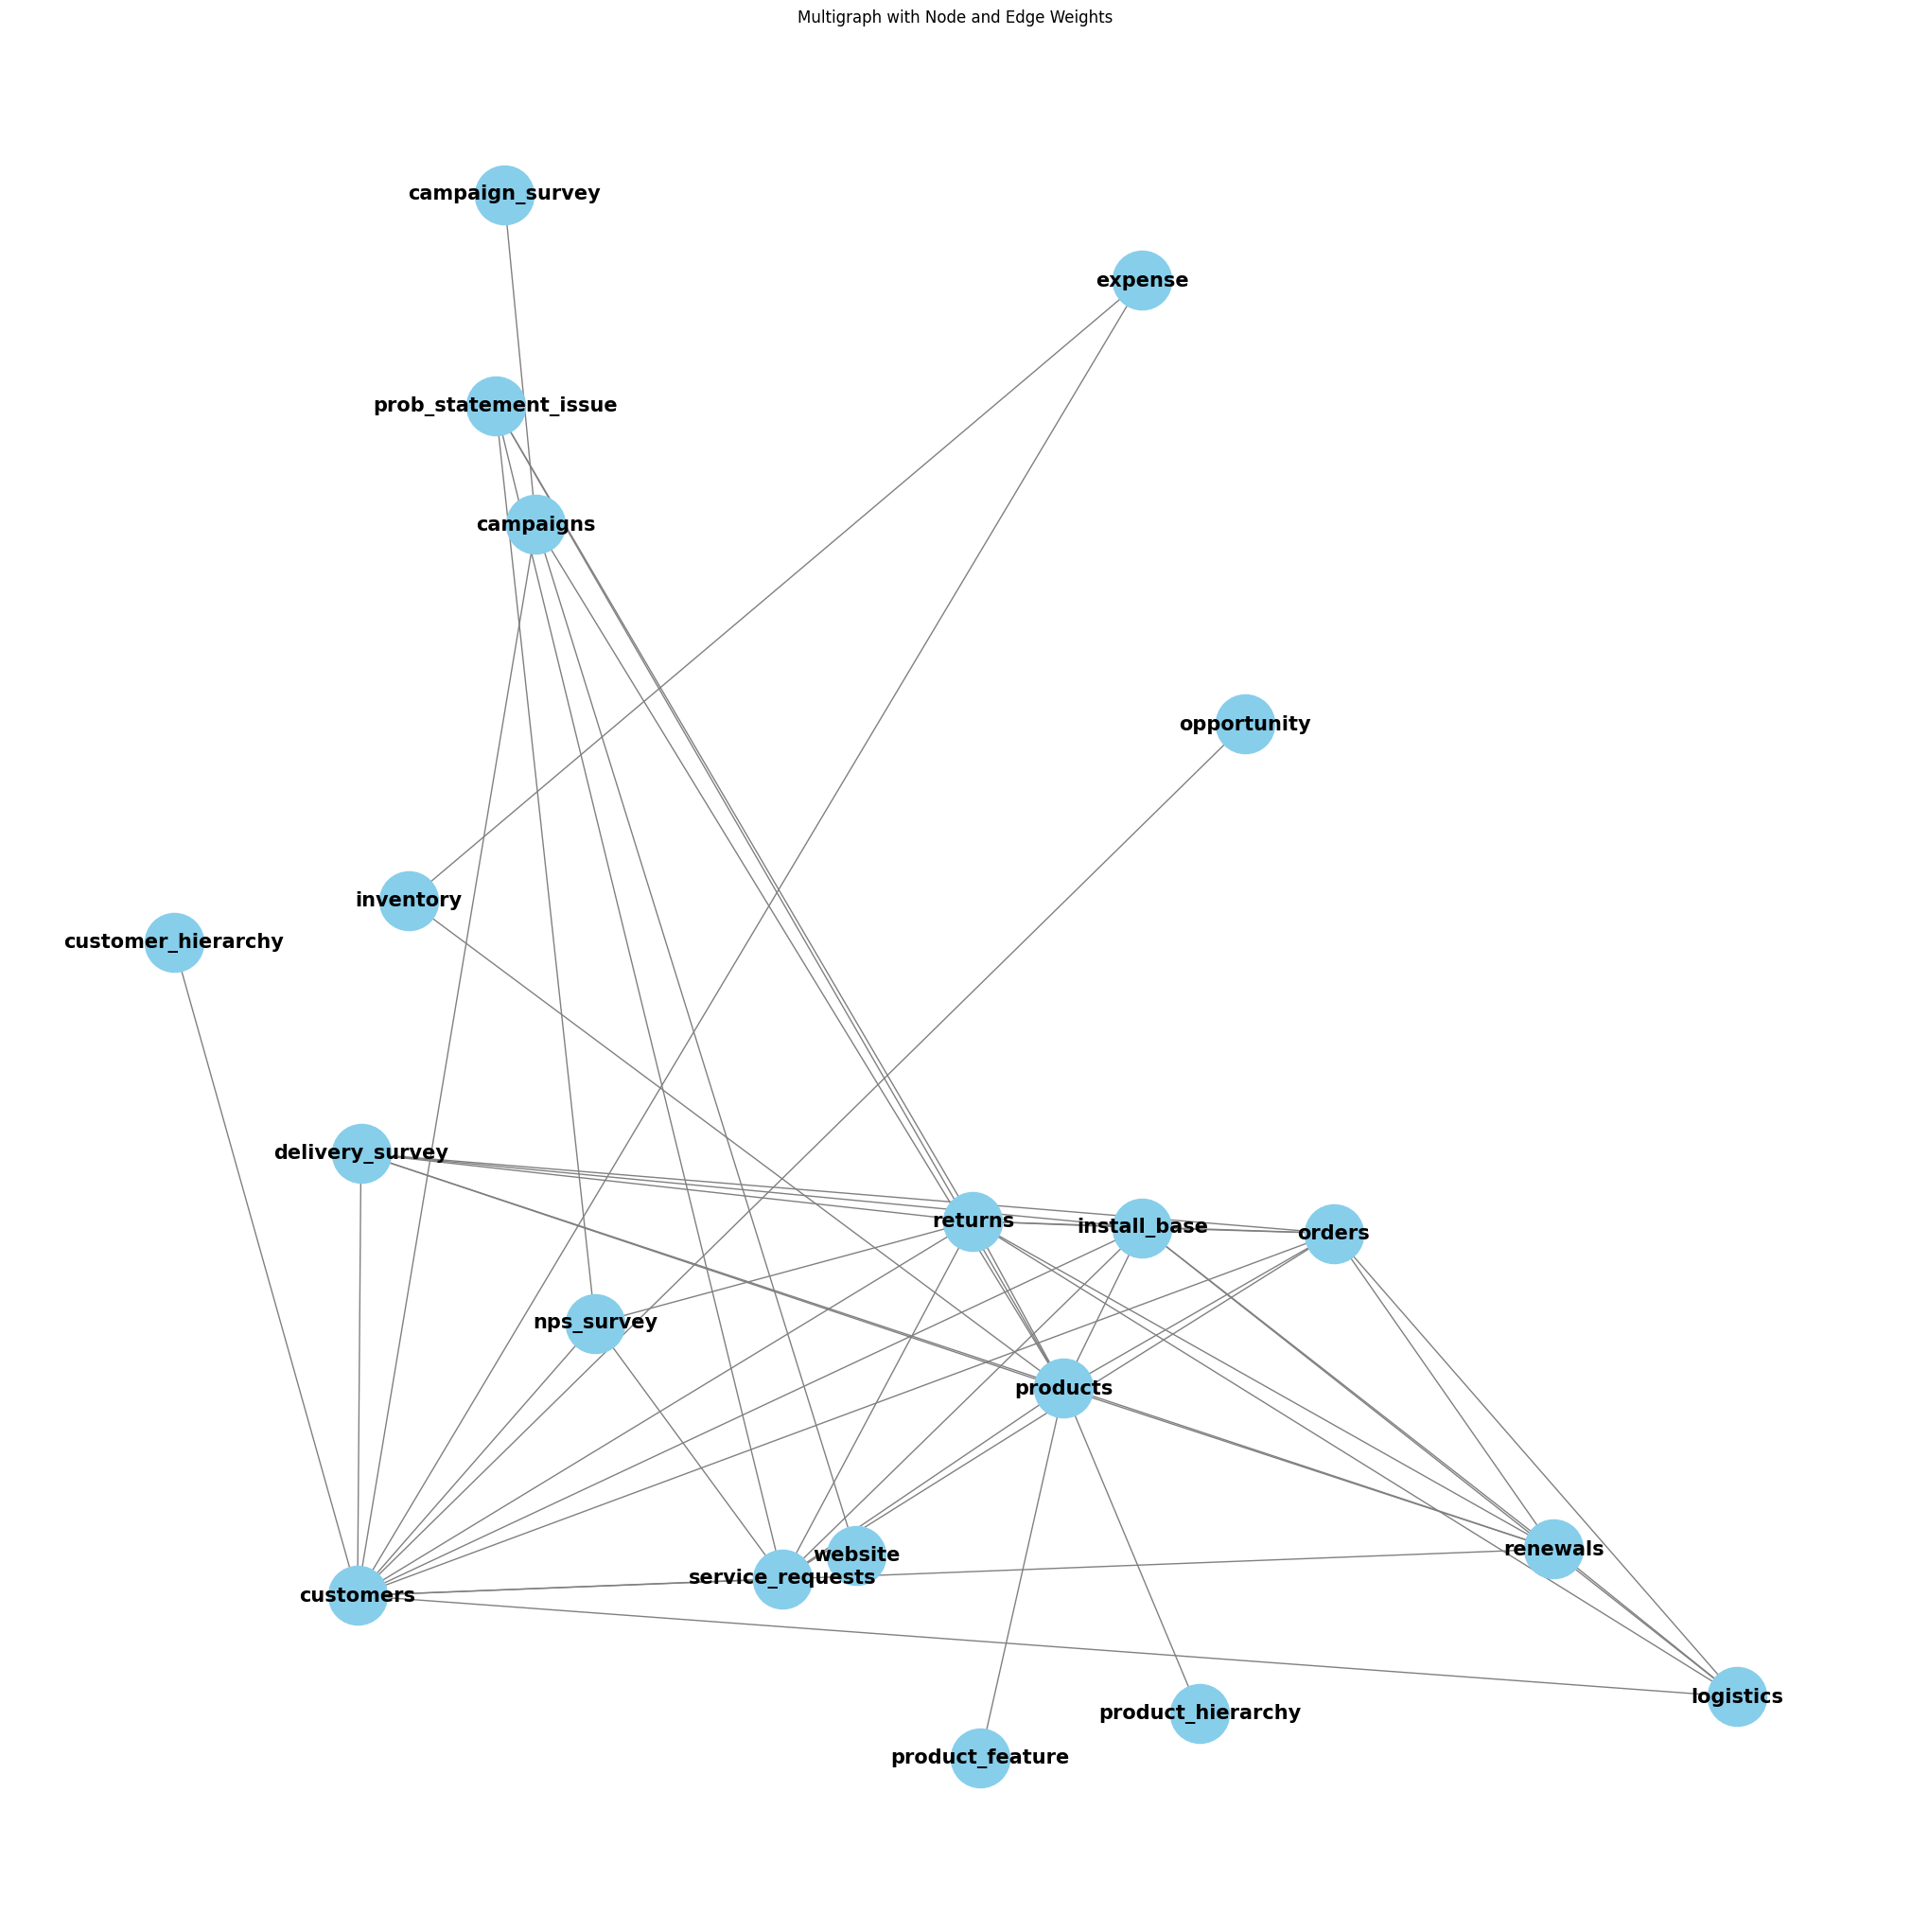

In [ ]:
kb.visualize()  # To visualize the relationships as a graph


## 4. The Semantic Layer

The KnowledgeBuilder results are used to generate YAML files which are saved automatically. These files defines the semantic layer, including the models (tables) and their relationships. 

By default, these files are saved in the current working directory. You can configure this path by setting the `PROJECT_BASE` environment variable.


## 5. Semantic Search

The semantic search feature allows you to search for columns in your datasets using natural language. 

> **Note:** To use this feature, you need to have a running Qdrant instance and an OpenAI API key. Please refer to the [README.md](README.md) for detailed setup instructions.

Once you have built the knowledge base, you can use the `search` method to perform a semantic search. The search function returns a pandas DataFrame containing the search results, including the column's profiling metrics, category, table name, and table glossary.


In [24]:
# Perform a semantic search
search_results = kb.search("customer orders")

# View the search results
search_results

/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/vector_store/qdrant.py:77: UserWarning: Api key is used with an insecure connection.
  self._client = AsyncQdrantClient(**self.client_config)
/home/raphael/Downloads/intugle_demo/env/lib/python3.12/site-packages/intugle/core/semantic_search/semantic_search.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  late_embedding_result_glossary["score"] = late_embedding_result_glossary["score"] / len(late_vector)


,column_id,score,relevancy,column_name,column_glossary,column_tags,category,table_name,table_glossary,uniqueness,completeness,count,null_count,distinct_count,sample_data
0,orders.Order Status,0.930471,most-relevant,Order Status,Indicates the current state or outcome of an o...,"[Order Lifecycle, Fulfillment Status, Customer...",dimension,orders,"Captures details of customer transactions, inc...",0.001,1.0,5000,0,5,"[Returned, In Progress, Cancelled, Shipped, De..."
1,nps_survey.Customer_ID,0.925135,most-relevant,Customer_ID,Identifies individuals or entities participati...,"[Customer Identifier, Survey Respondent, Custo...",dimension,nps_survey,"Captures customer feedback, satisfaction score...",0.615,1.0,1000,0,615,"[CUST-10388, CUST-10839, CUST-10140, CUST-1053..."
2,returns.Customer ID,0.925055,most-relevant,Customer ID,Identifies the individual or organization asso...,"[Customer Identification, Returns Management, ...",dimension,returns,"Tracks customer-initiated product returns, cap...",0.652,1.0,1000,0,652,"[CUST-10373, CUST-10338, CUST-10277, CUST-1095..."
3,delivery_survey.Customer ID,0.925055,most-relevant,Customer ID,Uniquely identifies a customer participating i...,"[Customer Identifier, Survey Respondent, Deliv...",dimension,delivery_survey,"Captures customer feedback, delivery satisfact...",0.627,1.0,1000,0,627,"[CUST-10922, CUST-10726, CUST-10506, CUST-1029..."
4,customers.Address,0.923417,most-relevant,Address,Location information associated with a custome...,"[Mailing Address, Customer Location, Military ...",dimension,customers,"Captures key details about organizations, incl...",1.000,1.0,1000,0,1000,"[USS Johnson, FPO AA 67889, 45328 Bradley Trac..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,install_base.Product ID,0.809443,relevant,Product ID,Identifies individual products within the comp...,"[Product Identifier, Inventory Tracking, Insta...",dimension,install_base,"Tracks customer orders, including product deta...",0.630,1.0,1000,0,630,"[PROD-11532, PROD-11363, PROD-11276, PROD-1120..."
189,inventory.Storage Condition,0.809160,relevant,Storage Condition,Defines the environmental or regulatory requir...,"[Environmental Requirements, Inventory Classif...",dimension,inventory,"Tracks the availability, status, and location ...",0.003,1.0,1000,0,3,"[Normal, Restricted, Climate-Controlled]"
190,inventory.Product Name,0.806103,relevant,Product Name,Identifies the specific product available in t...,"[Product Catalog, Network Equipment, Technolog...",dimension,inventory,"Tracks the availability, status, and location ...",0.005,1.0,1000,0,5,"[CloudHub Gateway, SmartEdge Router, Nova Fire..."
191,products.Product ID,0.804653,relevant,Product ID,Uniquely identifies a product within the compa...,"[Product Identifier, Inventory Management, Cat...",dimension,products,"Tracks the lifecycle, categorization, and mana...",1.000,1.0,1000,0,1000,"[PROD-11043, PROD-11099, PROD-11232, PROD-1126..."


## 6. Data Product Creation

The semantic layer serves as a foundation for the DataProductBuilder, which streamlines the creation of reusable data products. This allows you
to encapsulate business logic and create standardized, trustworthy data assets that can be easily shared and reused across different teams and 
applications.

Let's define the model for the data product we want to build:

In [ ]:
data_product_config = {
  "name": "product_performance_and_returns",
  "fields": [
    {
      "id": "products.Product Name",
      "name": "product_name",
      "category": "dimension"
    },
    {
         "id": "products.Product Category",
         "name": "product_category",
         "category": "dimension"
       },
       {
         "id": "orders.Order Value ($)",
         "name": "total_sales_revenue",
         "category": "measure",
         "measure_func": "sum"
       },
       {
         "id": "returns.Return Value ($)",
         "name": "total_return_value",
         "category": "measure",
         "measure_func": "sum"
       },
       {
         "id": "returns.Return_ID",
         "name": "number_of_returns",
         "category": "measure",
         "measure_func": "countDistinct"
       },
       {
         "id": "orders.Order ID",
         "name": "number_of_orders",
         "category": "measure",
         "measure_func": "countDistinct"
       }
     ],
     "filter": {
       "selections": [],
       "wildcards": [],
       "sort_by": [
         {
           "id": "orders.Order Value ($)",
           "alias": "total_sales_revenue",
           "direction": "desc"
         }
       ],
       "limit": 1000
     }
   }

Now, let's use the `DataProductBuilder` to generate the data product:

In [ ]:
from intugle.dp_builder import DataProductBuilder

# Create a DataProductBuilder
dp_builder = DataProductBuilder()

# Generate the data product
data_product = dp_builder.build(data_product_config)

data_product.to_df()


campaign_survey loaded
website loaded
expense loaded
product_feature loaded
renewals loaded
nps_survey loaded
customer_hierarchy loaded
products loaded
service_requests loaded
product_hierarchy loaded
inventory loaded
customers loaded
campaigns loaded
opportunity loaded
orders loaded
prob_statement_issue loaded
delivery_survey loaded
returns loaded
install_base loaded
logistics loaded
product_performance_and_returns
product_performance_and_returns loaded


,product_name,product_category,total_sales_revenue,total_return_value,number_of_returns,number_of_orders
0,CloudEdge,Analytics,744371.0,142151.0,57,54
1,CloudEdge,Security,692871.0,116077.0,50,49
2,CoreAnalytics,Networking,657035.0,102221.0,51,46
3,DataSphere,Analytics,626508.0,106046.0,46,45
4,DataSphere,Networking,584554.0,101226.0,42,40
5,DataSphere,Cloud Platform,566411.0,128116.0,45,39
6,CloudEdge,IoT,552302.0,94908.0,36,34
7,CoreAnalytics,Analytics,540459.0,92259.0,42,39
8,NetConnect,Cloud Platform,527363.0,123900.0,43,39
9,CloudEdge,Cloud Platform,524343.0,94432.0,37,36


The `generate_product` function returns a `DataSet` object. You can also view the generated SQL query used for creating the data product:


In [18]:
# The generated SQL query
data_product.sql_query



'SELECT "products"."Product Name" as product_name, "products"."Product Category" as product_category, sum("orders"."Order Value ($)") as total_sales_revenue, sum("returns"."Return Value ($)") as total_return_value, count(distinct "returns"."Return_ID") as number_of_returns, count(distinct "orders"."Order ID") as number_of_orders FROM returns LEFT JOIN orders ON "orders"."Order ID" = "returns"."R Order ID" LEFT JOIN products ON "orders"."Product ID" = "products"."Product ID" GROUP BY "products"."Product Name" , "products"."Product Category" ORDER BY total_sales_revenue DESC LIMIT 1000'

## Conclusion

You've learned how to:

*   Configure your LLM provider and Embeddings provider.
*   Build a knowledge base using the `KnowledgeBuilder`.
*   Access enriched metadata, business glossaries and visualize the relationships between your tables.
*   Perform semantic search on your knowledge base.
*   Generate data products from the semantic layer using the `DataProductBuilder`.

This is just a starting point. This project has many other features to explore. We encourage you to try it with your own data and see how it can help you build a powerful semantic layer.